# Guerlédan 2024/02: seabot

To do:

- compute averaged spectra
- add transfer function estimates and leverage for interpretation spectral analysis (relative displacement vs isopycnal displacement ratio)
- reconstruct dynamics (use float library), estimate $V_{air}$
- do we need to look at other deployments?
- `test_guerledan_2024_02_09/night/seabot5/rosbag2_2024_02_08-21_00_48/data/observer/temperature.npz` is empty
- animate float behavior for illustration purposes
- compare measured depth with that interpolated from the bathymetric map and an estimate of the position - road to horizontal position assessment

Question: par quoi la variabilité de température est-elle contrôlée? Hypothèse: capteur, bruit haute fréquence (vérifier )

To improve in future deployments:

- collect independent GPS fixes at deployments/recoveries
- avoid corrupted GPS data streams
- vertical profile missions are not continuously ascending and descending which complicates having consistent clean vertical profile of hydrology

In [1]:
import os
from glob import glob
from flatten_dict import flatten

import xarray as xr
import pandas as pd
import numpy as np
from scipy.signal import lfilter

#%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('figure', titlesize=10)
plt.rc('axes', titlesize=10)
import hvplot.pandas # noqa
from cmocean import cm

import pynsitu as pin

/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/utide/harmonics.py:16: RuntimeWarning: invalid value encountered in cast
  nshallow = np.ma.masked_invalid(const.nshallow).astype(int)
/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/utide/harmonics.py:17: RuntimeWarning: invalid value encountered in cast
  ishallow = np.ma.masked_invalid(const.ishallow).astype(int) - 1


In [2]:
## will end up in lib file eventually

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

#root_path = "/Users/aponte/Current_Projects/ensta/guerledan_202310/data_seabot"
root_dir = "/Users/aponte/Current_Projects/ensta/guerledan/"

# guerledan coords
g_lon, g_lat = 48.1964758, -3.0196383

def load_rosbag(
    data_dir, 
    set_time=False, 
    verbose=False, 
    _browse=True,
):
    """ load rosbag data in a directory
    
    Parameters
    ----------
    data_dir: str
        path to data directory where rosbag files are
    verbose: boolean, optional
        activates verbosity
    set_time: boolean, optional
        set time from GPS data
    _browse: boolean, optional
        used for internal recursions when multiple rosbags are encountered

    Returns
    -------
    D: dict
        Dictionary containing data
    
    """

    # move deeper in dir tree
    if _browse:
        ros_dir = sorted(os.listdir(data_dir))
        ros_dir = [d for d in ros_dir if "." not in d]
        #assert len(ros_dir)==1, ("multiple rosbags?", data_dir)
        if len(ros_dir)>1:
            print("multiple rosbags encountered in "+data_dir)
            return {
                d: 
                load_rosbag(
                    os.path.join(data_dir, d), verbose=verbose, set_time=set_time, _browse=False
                )  
                for d in ros_dir
            }
        else:
            ros_dir = ros_dir[0]
    else:
        ros_dir = data_dir.split("/")[-1]
        data_dir = "/".join(data_dir.split("/")[:-1])
    
    # extract timestamp
    print(ros_dir.replace('rosbag2_', ''))
    time_start = pd.to_datetime(ros_dir.replace('rosbag2_', ''), format="%Y_%m_%d-%H_%M_%S")
    ros_dir = os.path.join(data_dir, ros_dir)
    if not "data" in os.listdir(ros_dir):
        if verbose: print("no data directory in :"+ros_dir)
        return
    data_dir = os.path.join(ros_dir, "data")

    # start walking content
    content = sorted(os.listdir(data_dir))
    dirs = [c for c in content if os.path.isdir(os.path.join(data_dir, c))]
    files = [c for c in content if os.path.isfile(os.path.join(data_dir, c))]

    D = {}
    for d in dirs:

        if verbose: print(f"{d}") 

        subcontent = sorted(os.listdir(os.path.join(data_dir, d)))

        if not subcontent:
            if verbose: print("no data found in : ", data_dir, d)
            continue
            
        c = subcontent[0]
        for c in subcontent:
            if ".npz" in c:
                label = c.replace(".npz", "")
                file_path = os.path.join(data_dir, d, c)
                try:
                    with np.load(file_path, allow_pickle=False) as data:
                        df = pd.DataFrame({k: v for k, v in data.items()})
                    D[d+"_"+label] = df
                    if verbose: print(f"  {label}: "+" / ".join(c for c in df.columns))
                except Exception as err:
                    if verbose:
                        print(f"Unexpected {err=}, {type(err)=}")
                        print(file_path)
            else:
                if verbose: print(f"{c} skipped")
        
    # fix time:
    if set_time=="gps" and "driver_fix" in D:
        # get GPS time to set a proper clock
        # note that a clock drift could be computed
        df = D["driver_fix"]
        dt = np.mean( df["time_gnss"] - df["time"] )
        # could collect start/end positions
        for k, df in D.items():
            if "time" in df.columns:
                df["time_posix"] = df["time"] + dt
                df["time"] = pd.to_datetime(df["time_posix"], unit="s")
            D[k] = df.set_index("time").sort_index()
    else:
        if verbose: print("use rosbag filename to set time")
        for k, df in D.items():
            if "time" in df.columns:
                df["time_since_start"] = pd.to_timedelta(df["time"], unit="s")
                df["time"] = time_start + df["time_since_start"]
            D[k] = df.set_index("time").sort_index()
    
    # could collect general informations
    D["data_dir"] = data_dir
    
    return D

# with allow_pickle=False cannot load : observer/parameter.npz and driver/profile.npz
# driver_profile: distance / confidence / transmit_duration / ping_number / scan_start / scan_length / gain_setting / profile_data_length / profile_data / time_posix

def walk_load_repo(data_dir, _top=True, **kwargs):
    """ walk data repository and load rosbags
    
    
    """
    content = sorted(os.listdir(data_dir))
    content = [c for c in content if c not in [".DS_Store"]]
    if any(["rosbag" in c for c in content]):
        return load_rosbag(data_dir, **kwargs)
    else:
        D = {c: walk_load_repo(os.path.join(data_dir, c), _top=False, **kwargs) for c in content}
        if _top:
            D = flatten(D)
        return D

def dfilter(D, key):
    """ select a key in a flatten data dict """
    Do = {}
    for k, v in D.items():
        if key in k:
            kn = list(k)
            kn.remove(key)
            Do[tuple(kn)] = v
    return Do

def combine(D, rule, *keys, op="median"):
    """ resample and combine multiple keys
    The input dict must be flattened
    
    Dout = combine(D, "1s", "observer_kalman", "observer_temperature")
    """

    _D = dfilter(D, keys[0])
    Dout = {}
    for k_out in list(_D):
        _D = []
        for k_in in keys:
            k = k_out+(k_in,)
            if k in D:
                df = D[k]
                _D.append(df.resample("1s").apply(op))
        Dout[k_out] = pd.concat(_D, join="inner", axis=1)
    return Dout

def match_dict_cp(D, cp):
    """ match data dict keys with yaml file info """
    Dd = dfilter(D, "data_dir")

    M = {}
    for plabel, p in cp.platforms.items():
        if "seabot" in plabel:
            for dlabel, d in p["deployments"].items():
                if "data_dir" in d:
                    data_dir = d["data_dir"]
                    #print(plabel, dlabel, data_dir)
                    for key, Ddata_dir in Dd.items():
                        #print(plabel, dlabel, Ddata_dir) 
                        if data_dir in Ddata_dir:
                            #print(plabel, dlabel, Ddata_dir) 
                            #break
                            M[(plabel, dlabel)] = key
    return M

def append_depth_filtered(df, tau):
    """ filter pressure, inplace """
    #dt, tau = 1, 2.5
    dt = 1
    alpha = dt/2/tau
    b, a = [alpha], [1, -(1-alpha)]
    df["depth_filtered"] = lfilter(b, a, df.depth.bfill())
    dt = (df.reset_index()["time"].diff().bfill() / pd.Timedelta("1s")).values
    df["velocity_filtered"] = df["depth_filtered"].diff().bfill().values / dt

def plot_depth(D, legend=True):
    """ plot depth for all deployments """

    colors = pin.get_cmap_colors(len(D))

    fig, ax = plt.subplots(1,1, figsize=(15,4))
    for key, c in zip(D, colors):
        if isinstance(key, tuple):
            df = D[key]
        else:
            df = key
        ax.plot(df.index, -df.depth, color=c, label="/".join(key))
    ax.grid()
    if legend:
        ax.legend()
    
    return fig, ax

def hv_plot(D, v, revert_yaxis=False):
    
    colors = pin.get_cmap_colors(len(D))
    
    p = None
    for key, c in zip(D, colors):
        if isinstance(key, tuple):
            df = D[key]
        else:
            df = key
        if p is None:
            if v in df:
                p = df[v].hvplot(color=c, grid=True)
        else:
            if v in df:
                p = p * df[v].hvplot(color=c)
    
    if revert_yaxis:
        p = p.opts(invert_yaxis=True)
    
    return p


def show_gps(Dp, i, start, full=False):
    """ show start/end gps tracks """

    key = list(Dp)[i]
    #print(key)

    df = Dp[key]
    dfk = Dk[key]

    # extract start/end times
    depth_threshold = 0.5
    dt_threshold = pd.Timedelta("5min")

    dfk = Dk[key]
    start = dfk.loc[dfk.depth>depth_threshold].index[0]
    end = dfk.loc[dfk.depth>depth_threshold].index[-1]

    #dfs = df.loc[ (df.index<start) & (df.index>start-dt_threshold) ]
    dfs = df.loc[ (df.index<start) ]
    #dfs.plot(subplots=True, figsize=(10,10), layout=(5, 5));

    #dfe = df.loc[ (df.index>end) & (df.index<end+dt_threshold) ] 
    dfe = df.loc[ (df.index>end) ]
    #dfe.plot(subplots=True, figsize=(10,10), layout=(5, 5));

    if full:
        _df, _dfk = df, dfk
    elif start:
        _df, _dfk = dfs, dfk.loc[dfk.index<start]
    else:
        _df, _dfk = dfe, dfk.loc[dfk.index>end]

    return (
        _dfk["depth"].hvplot()
        +_df["mode"].hvplot()
        +_df["longitude"].hvplot() 
        +_df["latitude"].hvplot() 
    ).cols(2)

def load_gps(deployment, Dp):
    """ load gps positions based on deployment dict, inplace"""

    for key in Dp:
        
        df = Dp[key]
        
        df = df.loc[ df["mode"]==3 ]
        
        if df.index.size>0 and key in deployment:
            start =  df.loc[ df.index>deployment[key]["start"] ].iloc[0]
            end =  df.loc[ df.index>deployment[key]["end"] ].iloc[0]

            _dict = dict(
                start_lon=float(start.longitude),
                start_lat=float(start.latitude),
                end_lon=float(end.longitude),
                end_lat=float(end.latitude),
            )
            deployment[key].update(**_dict)

def key2title(key, splitter):
    """ convert data dict key into a single string """
    key = [k.replace("test_guerledan_", "") for k in key]
    return splitter.join(key)

def pprint(D):
    """ pretty print data dict content"""
    fmt = "%Y/%m/%d %H:%M:%S"
    for d, df in D.items():
        start = df.index.min().strftime(fmt)
        end = df.index.max().strftime(fmt)
        print(" / ".join(d)+f" {start} to {end}")

# load data
def load_bathy(coverage):
    from pyproj import Transformer

    if coverage=="east":
        tiff_file = "Guerledan_Feb19_0.5m.tiff"
    tiff_path = os.path.join(root_dir, tiff_file)

    xds = (
        xr.open_dataset(tiff_path, engine="rasterio")
        .squeeze()
        .rename(band_data="height")
    )

    # compute lon/lat
    _, x, y = xr.broadcast(xds.height, xds.x, xds.y)
    transformer = Transformer.from_crs("EPSG:2154", "EPSG:4326")
    ll = transformer.transform(x, y)
    xds["lat"], xds["lon"] = ((x.dims, l) for l in ll)
    xds = xds.set_coords(["lon", "lat"])
    
    return xds

def plot_map(
    coverage="east", extent=None,
    bathy=False, dx=10, 
    tile=True, tile_level=None,
    figsize=(5,5),
):
    """ plot bathymetry Guerledan
    
    Parameters
    ----------
    coverage
    """
    
    fig = plt.figure(figsize=figsize)

    if coverage=="full":
        _extent, level = [-3.1, -3., 48.19, 48.22], 12 # large
    elif coverage=="east":
        _extent, level = [-3.04, -3.01, 48.193, 48.205], 15 # east
    if tile_level is None:
        tile_level = level
    if extent is None:
        extent = _extent
        
    akwargs = dict()
    if tile:
        #tile = cimgt.GoogleTiles(style='terrain')
        #tile = cimgt.GoogleTiles(style='street')
        tile = cimgt.OSM()
        proj = tile.crs
    else:
        #lon, lat = float(ds.lon.mean()), float(ds.lat.mean())
        lon = (extent[0]+extent[1])*.5
        lat = (extent[2]+extent[3])*.5
        proj = ccrs.LambertAzimuthalEqualArea(central_longitude=lon, central_latitude=lat)
        akwargs.update(facecolor=cfeature.COLORS['land'])
    
    ax = fig.add_subplot(111, projection=proj, **akwargs)
    ax.set_extent(extent, crs=crs)

    if bathy:
        ds = load_bathy(coverage).isel(x=slice(0,None,dx), y=slice(0,None,dx))
        height = ds.height - ds.height.min()
        hdl = ax.pcolormesh(ds.lon, ds.lat, height, transform=crs)

    if tile:
        ax.add_image(tile, tile_level)
    else:
        gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
        gl.right_labels = False
        gl.top_labels = False
    if bathy:
        fig.colorbar(hdl)
    
    return fig, ax

In [3]:
seabot_dir = os.path.join(root_dir, "202402/data_raw/data_seabot")
D = walk_load_repo(seabot_dir)

cp = pin.Campaign("guerledan_202402.yaml")
M = match_dict_cp(D, cp)

2024_02_05-20_06_37
2024_02_05-20_06_54
2024_02_06-15_11_30
2024_02_06-15_08_44
multiple rosbags encountered in /Users/aponte/Current_Projects/ensta/guerledan/202402/data_raw/data_seabot/test_guerledan_2024_02_06/test_emission_inter_flotteur/seabot1
2024_02_06-16_25_01
2024_02_06-16_57_08
2024_02_06-16_25_28
2024_02_06-17_20_16
2024_02_06-17_20_31
2024_02_07-15_37_15
2024_02_07-15_37_16
2024_02_09-11_04_43
2024_02_08-21_00_52
2024_02_08-21_00_48


In [4]:
# used to fill yaml file
Dk = dfilter(D, "observer_kalman")
pprint(Dk)

test_guerledan_2024_02_05 / seabot4 2024/02/05 20:06:44 to 2024/02/05 20:50:17
test_guerledan_2024_02_05 / seabot5 2024/02/05 20:06:56 to 2024/02/05 20:50:09
test_guerledan_2024_02_06 / test_15m / seabot1 2024/02/06 15:11:40 to 2024/02/06 15:37:41
test_guerledan_2024_02_06 / test_15m / seabot3 2024/02/06 15:08:47 to 2024/02/06 15:37:44
test_guerledan_2024_02_06 / test_emission_inter_flotteur / seabot1 / rosbag2_2024_02_06-16_25_01 2024/02/06 16:25:01 to 2024/02/06 16:45:17
test_guerledan_2024_02_06 / test_emission_inter_flotteur / seabot1 / rosbag2_2024_02_06-16_57_08 2024/02/06 16:57:08 to 2024/02/06 17:33:15
test_guerledan_2024_02_06 / test_emission_inter_flotteur / seabot3 2024/02/06 16:25:35 to 2024/02/06 17:26:17
test_guerledan_2024_02_07 / night / seabot4 2024/02/06 17:20:16 to 2024/02/07 08:45:10
test_guerledan_2024_02_07 / night / seabot5 2024/02/06 17:20:31 to 2024/02/07 08:45:35
test_guerledan_2024_02_08 / night / seabot4 2024/02/07 15:37:15 to 2024/02/08 08:53:00
test_guerle

In [5]:
Dk = dfilter(D, "observer_kalman")
Dt = dfilter(D, "observer_temperature")

colors = {d: c for d, c in zip(list(Dk), pin.get_cmap_colors(len(Dk)))}

# combine temperature and kalman data
Dkt = combine(D, "1s", "observer_kalman", "observer_temperature")
# append depth filtered to match temperature
for d, df in Dkt.items():
    append_depth_filtered(df, 2.)
# inspect if need be:
#df["depth"].hvplot() * df["depth_filtered"].hvplot()    

#### show sampling rates

In [6]:
def show_sampling_rate(D):
    keys = ["_".join(d) for d in list(D)]
    data = []
    for d, df in D.items():
        dt = df["time_since_start"].diff()/pd.Timedelta("1s")
        data.append(np.mean(dt))
    return pd.Series(data, index=keys)

for label in ["observer_kalman", "observer_temperature"]:
    _D = dfilter(D, label)
    s = show_sampling_rate(_D)
    print(f"-- {label}, dt (s):")
    print(s)

-- observer_kalman, dt (s):
test_guerledan_2024_02_05_seabot4                                                             0.200005
test_guerledan_2024_02_05_seabot5                                                             0.199855
test_guerledan_2024_02_06_test_15m_seabot1                                                    0.200002
test_guerledan_2024_02_06_test_15m_seabot3                                                    0.199999
test_guerledan_2024_02_06_test_emission_inter_flotteur_seabot1_rosbag2_2024_02_06-16_25_01    0.199997
test_guerledan_2024_02_06_test_emission_inter_flotteur_seabot1_rosbag2_2024_02_06-16_57_08    0.200015
test_guerledan_2024_02_06_test_emission_inter_flotteur_seabot3                                0.200009
test_guerledan_2024_02_07_night_seabot4                                                       0.200003
test_guerledan_2024_02_07_night_seabot5                                                       0.200001
test_guerledan_2024_02_08_night_seabot4      

#### show positions

In [7]:
#Dp = dfilter(Df, 'driver_fix')
Dp = dfilter(D, 'driver_fix')
pprint(Dp)

test_guerledan_2024_02_05 / seabot4 2024/02/05 20:06:44 to 2024/02/05 20:50:17
test_guerledan_2024_02_05 / seabot5 2024/02/05 20:06:57 to 2024/02/05 20:50:09
test_guerledan_2024_02_06 / test_15m / seabot1 2024/02/06 15:11:40 to 2024/02/06 15:37:41
test_guerledan_2024_02_06 / test_15m / seabot3 2024/02/06 15:08:44 to 2024/02/06 15:37:44
test_guerledan_2024_02_06 / test_emission_inter_flotteur / seabot1 / rosbag2_2024_02_06-16_25_01 2024/02/06 16:25:01 to 2024/02/06 16:45:17
test_guerledan_2024_02_06 / test_emission_inter_flotteur / seabot1 / rosbag2_2024_02_06-16_57_08 2024/02/06 16:57:09 to 2024/02/06 17:33:15
test_guerledan_2024_02_06 / test_emission_inter_flotteur / seabot3 2024/02/06 16:25:35 to 2024/02/06 17:26:17
test_guerledan_2024_02_07 / night / seabot4 2024/02/06 17:20:19 to 2024/02/07 08:45:09
test_guerledan_2024_02_07 / night / seabot5 2024/02/06 17:20:34 to 2024/02/07 08:45:35
test_guerledan_2024_02_08 / night / seabot4 2024/02/07 15:37:15 to 2024/02/08 08:53:01
test_guerle

Some of the GPS data is crazy (2024_02_07 and seabot 5)

In [8]:
#show_gps(Dp, 0, True)
#show_gps(Dp, 0, False)
#show_gps(Dp, 9, None, full=True)

In [9]:
# manually select good gps times
if cp["name"]=="guerledan_202402":
    # these are pushed in yaml file and that's the source that should be used
    deployments = {
        ('test_guerledan_2024_02_07', 'night', 'seabot5'): dict(start=pd.Timestamp("2024/02/06 17:26:32"), end=pd.Timestamp("2024/02/07 08:32:00") ),
        ('test_guerledan_2024_02_07', 'night', 'seabot4'): dict(start=pd.Timestamp("2024/02/06 17:30:25"), end=pd.Timestamp("2024/02/07 08:32:00") ),
        ('test_guerledan_2024_02_08', 'night', 'seabot5'): dict(start=pd.Timestamp("2024/02/07 15:50:40"), end=pd.Timestamp("2024/02/08 08:33:00") ),
        ('test_guerledan_2024_02_08', 'night', 'seabot4'): dict(start=pd.Timestamp("2024/02/07 15:50:45"), end=pd.Timestamp("2024/02/08 08:33:00") ),
        ('test_guerledan_2024_02_09', 'night', 'seabot5'): dict(start=pd.Timestamp("2024/02/08 21:12:18"), end=pd.Timestamp("2024/02/09 08:04:00") ),
        ('test_guerledan_2024_02_09', 'night', 'seabot4'): dict(start=pd.Timestamp("2024/02/08 21:12:12"), end=pd.Timestamp("2024/02/09 08:06:30") ),
    }
    blank = [('test_guerledan_2024_02_07', 'night', 'seabot5'), ('test_guerledan_2024_02_07', 'night', 'seabot4')]
load_gps(deployments, Dp) # inplace

# mask bad gps data
for b in blank:
    for k in ["start_lon", "start_lat", "end_lon", "end_lat"]:
        deployments[b][k] = None

# show
#deployments

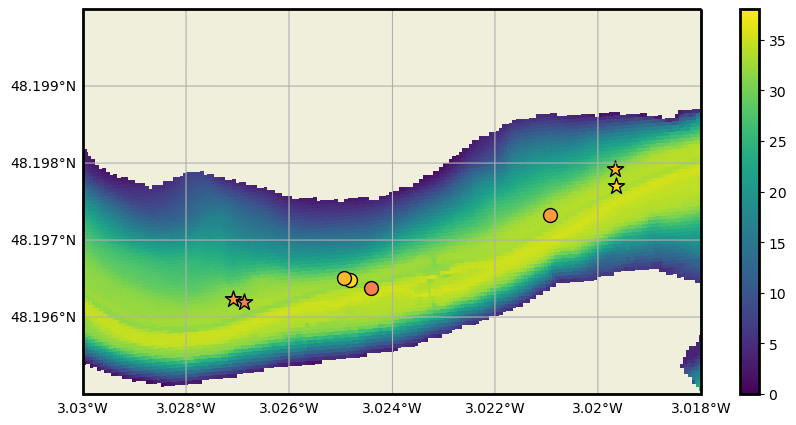

In [10]:
mapkw = dict(
    bathy=True, 
    figsize=(10,5),
    extent=[-3.03, -3.018, 48.195, 48.2],
    tile=False,
    #tile_level=16,
)
fig, ax = plot_map(**mapkw)

for d, info in deployments.items():
    c = colors[d]
    ax.scatter(info["start_lon"], info["start_lat"], s=100, c=c, marker="o", edgecolor="k", transform=crs)
    ax.scatter(info["end_lon"], info["end_lat"], s=150, c=c, marker="*", edgecolor="k", transform=crs) #, edgecolor="k")

**WARNING**

('test_guerledan_2024_02_08', 'seabot5') never aquired a good GPS fix at start up

Make sure GPS position is collected next times

We override with ('test_guerledan_2024_02_08', 'seabot4') start position plus a small (3m) offset

In [11]:
if cp["name"]=="guerledan_202402":
    for k in ["start_lon", "start_lat"]:
        deployments[('test_guerledan_2024_02_08', 'night', 'seabot5')][k] = \
            deployments[('test_guerledan_2024_02_08', 'night', 'seabot4')][k] + 3e-5

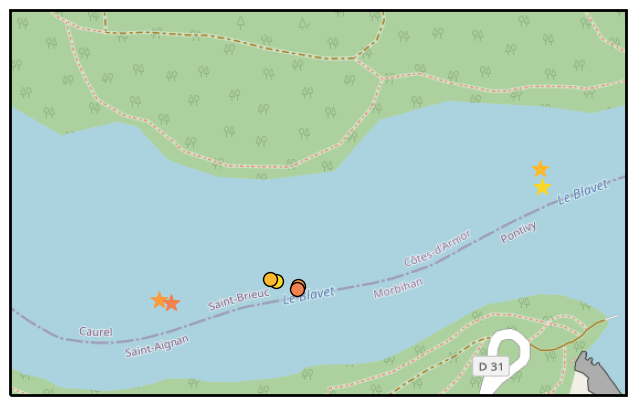

In [12]:
mapkw = dict(
    #bathy=True, 
    figsize=(10,5),
    extent=[-3.03, -3.018, 48.195, 48.2],
    #tile=False,
    tile_level=16,
)
fig, ax = plot_map(**mapkw)

for d, info in deployments.items():
    c = colors[d]
    #print(info["start_lon"], info["start_lat"])
    #print(info["end_lon"], info["end_lat"])
    ax.scatter(info["start_lon"], info["start_lat"], s=100, c=c, marker="o", edgecolor="k", transform=crs)
    ax.scatter(info["end_lon"], info["end_lat"], s=150, c=c, marker="*", transform=crs) #, edgecolor="k")


### overview of all dives

(<Figure size 1500x400 with 1 Axes>, <Axes: >)

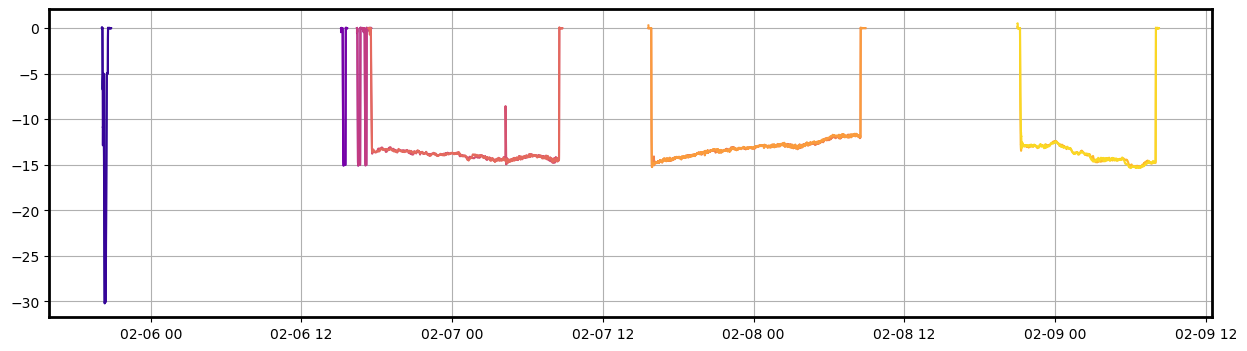

In [13]:
plot_depth(Dkt, legend=False)

In [14]:
#hv_plot(Dk, "depth", revert_yaxis=True)

### manually search for core deployment time periods for drift/scan experiments

In [15]:
pprint(Dkt)
#pprint(Dt)

test_guerledan_2024_02_05 / seabot4 2024/02/05 20:06:44 to 2024/02/05 20:50:17
test_guerledan_2024_02_05 / seabot5 2024/02/05 20:06:56 to 2024/02/05 20:50:09
test_guerledan_2024_02_06 / test_15m / seabot1 2024/02/06 15:11:40 to 2024/02/06 15:37:41
test_guerledan_2024_02_06 / test_15m / seabot3 2024/02/06 15:08:47 to 2024/02/06 15:37:44
test_guerledan_2024_02_06 / test_emission_inter_flotteur / seabot1 / rosbag2_2024_02_06-16_25_01 2024/02/06 16:25:01 to 2024/02/06 16:45:17
test_guerledan_2024_02_06 / test_emission_inter_flotteur / seabot1 / rosbag2_2024_02_06-16_57_08 2024/02/06 16:57:08 to 2024/02/06 17:33:15
test_guerledan_2024_02_06 / test_emission_inter_flotteur / seabot3 2024/02/06 16:25:35 to 2024/02/06 17:26:17
test_guerledan_2024_02_07 / night / seabot4 2024/02/06 17:20:16 to 2024/02/07 08:45:10
test_guerledan_2024_02_07 / night / seabot5 2024/02/06 17:20:33 to 2024/02/07 08:45:35
test_guerledan_2024_02_08 / night / seabot4 2024/02/07 15:37:15 to 2024/02/08 08:53:00
test_guerle

In [16]:
key = list(Dkt)[8]
print(key)
df = Dkt[key]

#(df["depth"].hvplot(grid=True)+df["velocity"].hvplot(grid=True)).cols(1)

('test_guerledan_2024_02_07', 'night', 'seabot5')


In [17]:
# select drift or scan period
Dcore = {}
for plabel, p in cp.platforms.items():
    for d in p["deployments"]:
        if "isoT" in d or "scan" in d:
            #cp["seabot4"]["drift0"]["iso_start"]
            print(plabel,d)
            key = M[(plabel, d)]
            if key in Dkt:
                Dcore[key] = Dkt[key].loc[cp[plabel][d]["iso_start"]:cp[plabel][d]["iso_end"]]

seabot4 isoT0
seabot4 isoT1
seabot4 isoT2
seabot5 isoT0
seabot5 isoT1
seabot5 isoT2


In [18]:
# mask bad parts:
Ma = None
if cp["name"]=="guerledan_202402":
    Ma = {
        ('test_guerledan_2024_02_07', 'night', 'seabot4'):slice("2024/02/07 04:13:30","2024/02/07 04:18:00"),
    }
if Ma is not None:
    for m in Ma:
        df = Dcore[m]
        Dcore[m] = df.loc[ (df.index<Ma[m].start) | (df.index>Ma[m].stop) ]

In [ ]:
(hv_plot(Dcore, "depth", revert_yaxis=True) 
 + hv_plot(Dcore, "temperature")
 + hv_plot(Dcore, "velocity") 
).cols(1)

---
## inspect, extract and store vertical profiles of stratification

### extract profile time interval

In [20]:
p, d = 'seabot5', "cast0"
m = M[(p, d)]

df = Dkt[m][["temperature", "depth"]].copy()
df.lon, df.lat = g_lon, g_lat
df["salinity"] = 0.

In [21]:
#df.sw.plot_bokeh(deployments=cp[p][d], cross=False)

### loop over casts and store vertical profile

In [128]:
prod = False

P = {}
for p, _p in cp.platforms.items():
    for d in _p["deployments"]:
        
        nc = os.path.join(cp["path_processed"], f'{p}_{d}.nc')
        
        if "cast" in d:
        
            if prod:
                #p, d = 'seabot5', "cast0"
                m = M[(p, d)]

                df = Dkt[m][["temperature", "depth"]].copy()
                df = df.ts.trim(cp[p][d])

                df.lon, df.lat = g_lon, g_lat
                df["salinity"] = 0.

                dfp = df.sw.compute_vertical_profile(0.5)
                dsp = dfp.to_xarray()
                
                # store
                P[f'{p}_{d}'] = dsp
                dsp.to_netcdf(nc, mode="w")
            else:
                
                P[f'{p}_{d}'] = xr.open_dataset(nc)

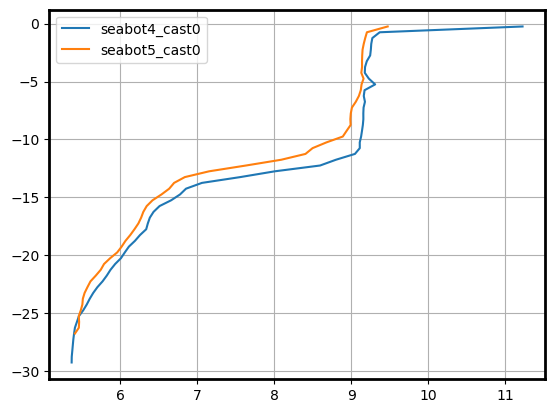

In [23]:
fig, ax = plt.subplots(1,1)
for c, df in P.items():
    ax.plot(df["temperature"], df.z, label=c)
ax.legend()
ax.grid()

In [24]:
if cp["name"]=="guerledan_202310":
    dTdz = 1.2 # degC/m # 2023/10
elif cp["name"]=="guerledan_202402":
    dTdz = 1. # degC/m # 2024/02

In [129]:
ds = P["seabot4_cast0"]

In [150]:
import gsw

Pa2dbar = 1e-4
g = 9.81

ds["rho"] = gsw.rho(ds.SA, ds.CT, ds.pressure)
ds["drhodz"] = ds["rho"].differentiate("z")
ds["dTdz"] = ds["temperature"].differentiate("z")
ds["Gamma_w"] = gsw.adiabatic_lapse_rate_from_CT(ds.SA, ds.CT, ds.pressure)/Pa2dbar
ds["gamma_w"] = gsw.kappa(ds.SA, ds.CT, ds.pressure)/Pa2dbar

# arbitrary
gamma_f = 2e-6 # nominal
#gamma_f = 2e-6 + 2e-5 # with "air"
alpha_f = 0.
c_d = 1e-4 # random choice
a = 1

In [151]:
ds["M2"] = g * (-ds.drhodz/ds.rho - alpha_f*ds.dTdz - gamma_f ) 
ds["N2"] = g * (-ds.drhodz/ds.rho - ds.gamma_w ) 
ds["L2"] = g * alpha_f * ( ds.dTdz + ds.Gamma_w )

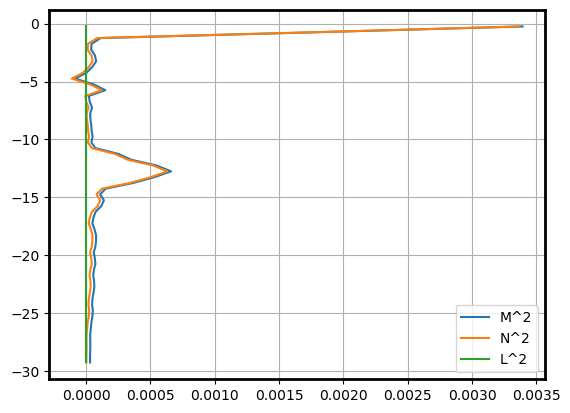

In [152]:
fig, ax = plt.subplots(1,1)

#ax.plot(np.sqrt(ds.M2), ds.z, label="M")
#ax.plot(np.sqrt(ds.N2), ds.z, label="N")
#ax.plot(np.sqrt(ds.L2), ds.z, label="L")

ax.plot(ds.M2, ds.z, label="M^2")
ax.plot(ds.N2, ds.z, label="N^2")
ax.plot(ds.L2, ds.z, label="L^2")

ax.legend()
ax.grid()

In [153]:
f_min = 1e-5
ds = ds.assign_coords(omega=("omega", np.arange(f_min, 1, f_min), dict(units="Hz")))

In [154]:
ds["H"] = (ds.M2-ds.N2+ds.L2) / (ds.M2 - (1+a)*(2*np.pi*ds.omega)**2 - 1j*(2*np.pi*ds.omega)*c_d )

In [158]:
#fig, ax = plt.subplots(1,1)
#np.log10(np.abs(ds["H"])).plot(ax=ax, vmax=2)
#np.abs(ds["H"]).plot(ax=ax, vmax=2)
#ax.set_xscale("log")

In [159]:
_ds = ds.sel(z=-12, method="nearest")

(-2.0, 2.0)

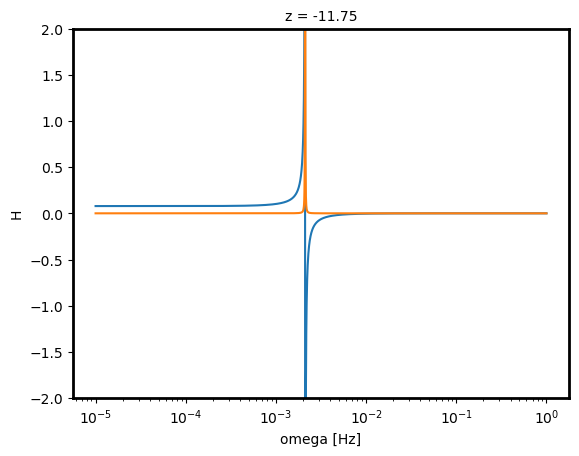

In [160]:
fig, ax = plt.subplots(1,1)
np.real(_ds["H"]).plot()
np.imag(_ds["H"]).plot()
ax.set_xscale("log")
ax.set_ylim(-2,2)

---

## isotherm following missions

In [25]:
iso_T = []
for plabel, p in cp.platforms.items():
    for d in p["deployments"]:
        if "isoT" in d:
            print(plabel,d)
            iso_T.append(M[(plabel, d)])


seabot4 isoT0
seabot4 isoT1
seabot4 isoT2
seabot5 isoT0
seabot5 isoT1
seabot5 isoT2


In [34]:
# buid dataset with isothermal displacement

Diso = {}
for d in iso_T:
    
    df = Dcore[d]
    
    #df["depth_anomaly"] = df["depth"] - df["depth"].mean()
    df["depth_anomaly"] = df["depth_filtered"] - df["depth_filtered"].mean()
    if "temperature" in df:
        df["temperature_anomaly"] = df["temperature"] - df["temperature"].mean()

        df["relative_displacement"] = df["temperature_anomaly"]/dTdz
        df["isotherm_displacement"] = df["relative_displacement"] + df["depth_anomaly"]
        # positive downwards
        # compensates for the float vertical displacement

        #df["temperature_rate_of_change"] =  (df["temperature"].diff()).bfill()

        # compute estimated
        #df["velocity_water"] = -df["temperature_rate_of_change"]/dTdz - df["velocity"]    
        dt = (df.reset_index()["time"].diff().bfill() / pd.Timedelta("1s")).values
        df["velocity_water"] = df["isotherm_displacement"].diff().bfill().values / dt
    
    Diso[d] = df

### global metrics of regulation

In [35]:
def plot_hist(D, v, bins, unit):

    fig, axes = plt.subplots(2, 3, figsize=(7,4), sharex=True, sharey=True)

    i = 0
    for d in list(D):
        df = D[d]
        ax = axes.T.flatten()[i]
        if v in df:
            df[v].plot.hist(
                ax=ax, bins=bins, density=True, 
                color=colors[d], 
                #label=" - ".join(d), #+df.index[0].strftime("%Y/%m/%d %H:%M")
            )
            std = df[v].std()
            ax.text(0.1, 0.9, f"std = {std:.3f} {unit}", size=8, transform=ax.transAxes)
        ax.grid()
        ax.set_title(key2title(d, " "))
        if i%2==1:
            ax.set_xlabel(f"[{unit}]")
        i+=1

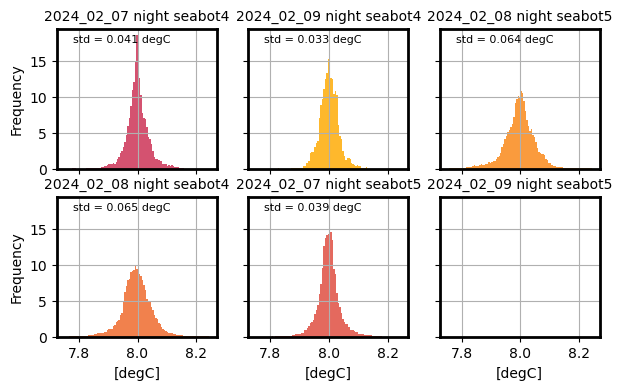

In [29]:
#bins = np.arange(13.8, 14.2, .005) # 2023/10
bins = np.arange(7.75, 8.25, .005) # 2024/02

plot_hist(Diso, "temperature", bins, "degC")        

not bad ... 😁 We must be close to instrument relative accuracy

Question is what controls these fluctuations (intrumental noise vs high frequency fluctuations)

0.05 degC in a 0.5 degC/m thermal gradient is equivalent to a 10 cm vertical displacement

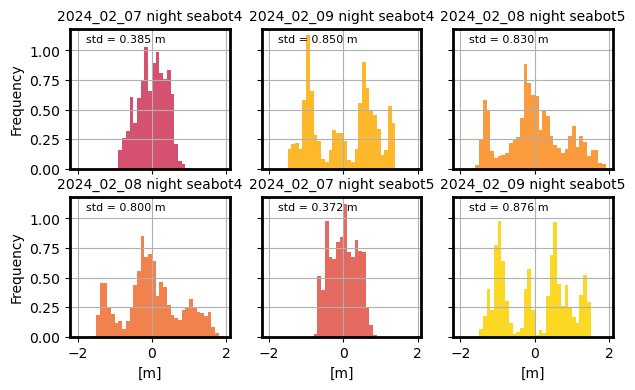

In [30]:
#bins = np.arange(13.8, 14.2, .005) # 2023/10
bins = np.arange(-2., 2., .1) # 2024/02

plot_hist(Diso, "depth_anomaly", bins, "m")        

2024/02: vertical displacements are meters like

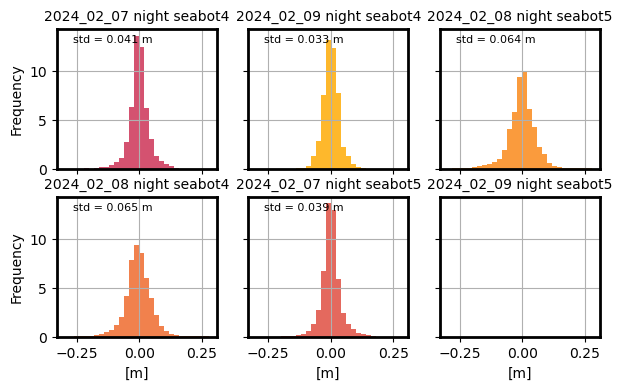

In [36]:
#bins = np.arange(13.8, 14.2, .005) # 2023/10
bins = np.arange(-.3, .3, .02) # 2024/02

plot_hist(Diso, "relative_displacement", bins, "m")        

2024/02: displacements relative to isotherms are about 5 cm (as expected), which is smaller than the float displacement and indicates the float successfully follows isotherms

2023/10: (to be verified) 2-3 cm is less that the vertical displacement (see next diagnostics) which confirms that depth variations do indeed reflect isotherm displacements

### time series

In [39]:
key = iso_T[3]
df = Diso[key]
print(key)

# show mean depth, temperature for this deployment
df["depth"].mean(), df["temperature"].mean()

('test_guerledan_2024_02_07', 'night', 'seabot5')


(13.95416313484656, 7.999783603109935)

In [ ]:
(
    df["depth_anomaly"].hvplot(grid=True) 
    * df["isotherm_displacement"].hvplot() 
    * (df["relative_displacement"]).hvplot()
    * (df["velocity"]*50).hvplot()
)

The float is able to follow low-frequency (> minutes) fluctuations but not higher frequency temperature fluctuations.
This limit may be related to the float natural dynamics and/or regulation response parameters (relaxation feedback constants).

Because of the temperature sensor, we can in theory compensate for this inability to follow isotherm.
This should thus be non-blocking for oceanographic applications.
This is provided internal waves are not "breathing" (dilating stratification).

The vertical velocity associated with high frequency isothermal displacement is about 50 cm / 3 min = 3 mm/s

In [ ]:
(
    df["velocity"].hvplot(grid=True) 
    * df["velocity_water"].hvplot()
)

### compute spectra

In [41]:
E = (
    df[
        ['depth', 'velocity',
         'depth_anomaly', 'temperature_anomaly',
         'temperature_anomaly_displacement', 'isotherm_displacement',
         'velocity_water',
        ]
    ]
    .ts.spectrum(unit="1s", nperseg="2H")
    .to_xarray()
)

Buoyancy period = 2.4 min


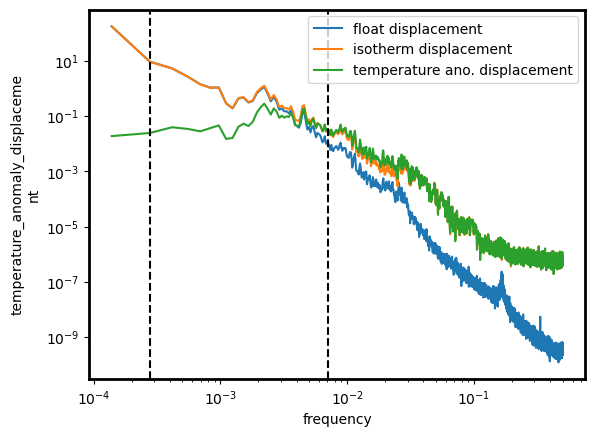

In [42]:
E = E.where(E.frequency>0, drop=True)

fig, ax = plt.subplots(1,1)

E["depth_anomaly"].plot(ax=ax, label="float displacement")
E["isotherm_displacement"].plot(ax=ax, label="isotherm displacement")
E["temperature_anomaly_displacement"].plot(ax=ax, label="temperature ano. displacement")

# buoyancy frequency
N = np.sqrt( 9.81 * 2e-4 * dTdz )
print(f"Buoyancy period = {2*np.pi/N/60:.1f} min")
ax.axvline(N/2/np.pi, color="k", ls="--")
ax.axvline(1/3600, color="k", ls="--")

ax.set_xscale("log")
ax.set_yscale("log")

ax.legend()

---

## temperature delay - to be updated

#### 1. simple offset on temperature: 

Seems to work within the water column but not at deepest levels nor at the surface

In [ ]:
key = list(Dkt)[1]
print(key)
df = Dkt[key]

fig, ax = plt.subplots(1,1)

delays = ["0s", "-2s", "-4s"]
_colors = pin.get_cmap_colors(len(delays))

for delay, c in zip(delays, _colors):
    _df = df.copy()
    _df["temperature"] = _df["temperature"].shift(freq=delay) # avance
    #_df.plot.scatter("temperature","depth", s=1, c=c, ax=ax, label=delay)
    ax.plot(_df.temperature, _df.depth, color=c, label=delay)

ax.invert_yaxis()
ax.grid()
ax.legend()
ax.set_xlim(None,10)

#### 2. low-pass filter depth instead

seems to behave similarly, 2s seconds seems a reasonable choice

In [ ]:
df = DF[0]

fig, ax = plt.subplots(1,1)

taus = [2, 3, 4]
_colors = pin.get_cmap_colors(len(taus))

for tau, c in zip(taus, _colors):
    _df = df.copy()
    append_depth_filtered(_df, tau)
    ax.plot(_df.temperature, _df.depth_filtered, label=f"tau={tau}")

ax.invert_yaxis()
ax.grid()
ax.legend()

---

## thermocline scanning experiment - to be updated

In [ ]:
def plot_scatter(df):

    fig, ax = plt.subplots(1,1, figsize=(10, 5))

    _df = df.reset_index()
    _df = _df.loc[_df.velocity>0] # downward profiles

    _df.plot.scatter("time", "depth_filtered", c="temperature", s=8, ax=ax, cmap=cm.thermal)
    ax.grid()

    ax.invert_yaxis()

#

In [ ]:
plot_scatter(DT[9])
plot_scatter(DT[11])

In [ ]:
# with hvplot

#df = DT[9]
#df = df.reset_index()
#df = df.loc[df.velocity>0] # select downward profiles

#_df.hvplot.scatter("time", "depth", c="temperature", s=10, ax=ax, cmap=cm.thermal).opts(invert_yaxis=True)

#### depth-time bin average

In [ ]:
def depth_time_bin_average(df, dz=.1, freq="10T", ascent=False):

    df = df.reset_index()
    if ascent is None:
        pass
    elif ascent:
        df = df.loc[df.velocity<0] # select downward profiles
    else:
        df = df.loc[df.velocity>0] # select downward profiles
        

    dbins = np.arange(15, 20.5, dz)
    tbins = pd.date_range(df.time.iloc[0], df.time.iloc[-1], freq=freq)

    #df["depth_cut"] = pd.cut(df["depth"], dbins)
    df["depth_cut"] = pd.cut(df["depth_filtered"], dbins)
    df["time_cut"] = pd.cut(df["time"], tbins)


    dfb = df.groupby(["depth_cut", "time_cut"]).mean().reset_index()

    dfb["depth"] = dfb["depth_cut"].apply(lambda i: i.left)
    dfb["time"] = dfb["time_cut"].apply(lambda i: i.left)

    ds = dfb.set_index(["depth", "time",]).to_xarray()

    return ds


def bin_plot(df, **kwargs):

    ds = depth_time_bin_average(df, **kwargs)

    fig, ax = plt.subplots(1,1)

    #DT[8]["depth"].plot(ax=ax, color="k")
    #DT[10]["depth"].plot(ax=ax, color="0.3")
    DT[8]["depth_filtered"].plot(ax=ax, color="k")
    DT[10]["depth_filtered"].plot(ax=ax, color="0.3")

    ds["temperature"].plot(ax=ax, cmap=cm.thermal)
    ds["temperature"].plot.contour(ax=ax, levels=[12, 14, 16], colors="w")

    ax.invert_yaxis()
    ax.grid()

In [ ]:
bin_plot(DT[9], ascent=None)
bin_plot(DT[9], ascent=True)
bin_plot(DT[9], ascent=False)

In [ ]:
bin_plot(DT[11])

### archived material ...

In [ ]:
df = DT[9]

_df = df.reset_index()
_df["mask"] = 0.
_df["mask"].where(_df.velocity>0, other=1., inplace=True)

_df["mask_cumsum"] = _df["mask"].cumsum()

_df["mask_cumsum"].hvplot()

In [ ]:
df = DT[9]

_df = df.reset_index()

_df = _df.loc[_df.velocity>0] # downward profiles

dt = _df["time"].diff()/pd.Timedelta("1T")
print("Time intervals in minutes:")
print(np.unique(dt))

#(_df["time"].diff()/pd.Timedelta("1s")).plot.hist(bins=np.arange(0,10,1), log=True) #.plot()

In [ ]:
_df = df.reset_index()

_df = _df.loc[_df.velocity>0] # downward profiles
_dt = _df["time"].diff()/pd.Timedelta("1T")
bottom = _df.loc[_dt>1]

_df = df.reset_index()
_df = _df.loc[_df.velocity<0] # downward profiles
_dt = _df["time"].diff()/pd.Timedelta("1T")
top = _df.loc[_dt>1]

In [ ]:
(df.reset_index()["depth"].hvplot()
 * bottom["depth"].hvplot() 
 * top["depth"].hvplot() 
)